In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from concurrent.futures import ThreadPoolExecutor
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE

def exact_solver(problem, converter):
    print(problem)
    print(converter)
    #print("I AM HERE11")
    solver = NumPyMinimumEigensolverFactory()
    #print("I AM HERE12")
    calc = GroundStateEigensolver(converter, solver)
    #print("I AM HERE13")
    #result = calc.solve(problem)
    #print("I AM HERE14")
    return 0

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    #hamiltonian = electronic_energy.second_q_ops()["ElectronicEnergy"]
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):
    
    
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator')
        #backend.set_options(max_job_size=1,executor=euler_client)
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'qasm':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
     
    #result = exact_solver(problem,converter)
    
    #print(num_orb)
    #print(num_part)
    num_orb = 4
    init_state = HartreeFock(num_orb, num_part, converter)
    
    #print(init_state)
    #print(op)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 

    vqe_result = vqe.compute_minimum_eigenvalue(op)

    min_eng = vqe_result.eigenvalue

    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    #euler_client.close()
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
        
    return E

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])

    rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
    qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
    op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates):
    
    coordinate_list = []
    for i in range(len(coordinates)):
        coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:]])
    
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))

    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es = pool.starmap(task1, triples)

    for i in range(len(Es)):
        exp_dict[triples[i][0]]=Es[i]

    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
    finish = time.time()
    print("Took " + str(finish - start) + " seconds to find ground state")
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    start = time.time()
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces, vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates)
    
    #print(force_ops)
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    parallel_expectations(exp_dict,pauli_op_set,q_instance,psi_0)

    
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract 
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 100.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 128)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 0/500 [00:00<?, ?it/s]/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


ground state energy:  (-3.2094852397386386+0j)


Progress:   0%|          | 1/500 [00:08<1:12:10,  8.68s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.52s
ground state energy:  (-3.1998107375384173+0j)


Progress:   0%|          | 2/500 [00:15<1:04:52,  7.82s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.46s
ground state energy:  (-3.1756410733775664+0j)


Progress:   1%|          | 3/500 [00:24<1:07:04,  8.10s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.79s
ground state energy:  (-3.1419642911980747+0j)


Progress:   1%|          | 4/500 [00:32<1:07:48,  8.20s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.81s
ground state energy:  (-3.1019842727262277+0j)


Progress:   1%|          | 5/500 [00:41<1:09:12,  8.39s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.86s
ground state energy:  (-3.0591358956226706+0j)


Progress:   1%|          | 6/500 [00:49<1:09:09,  8.40s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.83s
ground state energy:  (-3.0148451395939113+0j)


Progress:   1%|▏         | 7/500 [01:01<1:16:44,  9.34s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 8.0s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.969473591178423+0j)


Progress:   2%|▏         | 8/500 [01:11<1:18:54,  9.62s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 7.12s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.79s
ground state energy:  (-2.9242722893708346+0j)


Progress:   2%|▏         | 9/500 [01:20<1:17:20,  9.45s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.89s
ground state energy:  (-2.8803232907972065+0j)


Progress:   2%|▏         | 10/500 [01:28<1:14:37,  9.14s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.78s
ground state energy:  (-2.8385184307206437+0j)


Progress:   2%|▏         | 11/500 [01:37<1:12:02,  8.84s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.83s
ground state energy:  (-2.7990193315657326+0j)


Progress:   2%|▏         | 12/500 [01:45<1:10:31,  8.67s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.85s
ground state energy:  (-2.7621163736514567+0j)


Progress:   3%|▎         | 13/500 [01:54<1:12:51,  8.98s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.99s
ground state energy:  (-2.7284449589254067+0j)


Progress:   3%|▎         | 14/500 [02:03<1:10:33,  8.71s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.77s
ground state energy:  (-2.6972403022611613+0j)


Progress:   3%|▎         | 15/500 [02:12<1:11:26,  8.84s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.85s
ground state energy:  (-2.6694563000965563+0j)


Progress:   3%|▎         | 16/500 [02:20<1:10:21,  8.72s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 1.1s
ground state energy:  (-2.6449857629738935+0j)


Progress:   3%|▎         | 17/500 [02:29<1:09:38,  8.65s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.623934923369684+0j)


Progress:   4%|▎         | 18/500 [02:37<1:08:35,  8.54s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.6063325573849907+0j)


Progress:   4%|▍         | 19/500 [02:46<1:08:52,  8.59s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.94s
ground state energy:  (-2.5920264117914344+0j)


Progress:   4%|▍         | 20/500 [02:54<1:09:06,  8.64s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.8s
ground state energy:  (-2.5809302102987055+0j)


Progress:   4%|▍         | 21/500 [03:03<1:09:52,  8.75s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.86s
ground state energy:  (-2.573234290592921+0j)


Progress:   4%|▍         | 22/500 [03:12<1:09:29,  8.72s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.568604029231286+0j)


Progress:   5%|▍         | 23/500 [03:22<1:12:00,  9.06s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 2.91s, Calculate Covariance - 0.79s
ground state energy:  (-2.567310992550719+0j)


Progress:   5%|▍         | 24/500 [03:31<1:11:37,  9.03s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.5692405668503104+0j)


Progress:   5%|▌         | 25/500 [03:40<1:12:25,  9.15s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.85s
ground state energy:  (-2.5744939798909625+0j)


Progress:   5%|▌         | 26/500 [03:49<1:11:44,  9.08s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.84s
ground state energy:  (-2.5825822514753622+0j)


Progress:   5%|▌         | 27/500 [03:58<1:10:46,  8.98s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.91s
ground state energy:  (-2.5934907397615663+0j)


Progress:   6%|▌         | 28/500 [04:07<1:10:13,  8.93s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 1.0s
ground state energy:  (-2.6073729793100684+0j)


Progress:   6%|▌         | 29/500 [04:16<1:10:39,  9.00s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 1.1s
ground state energy:  (-2.6239297227459195+0j)


Progress:   6%|▌         | 30/500 [04:24<1:08:46,  8.78s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.9s
ground state energy:  (-2.642617302390728+0j)


Progress:   6%|▌         | 31/500 [04:33<1:08:40,  8.78s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.78s
ground state energy:  (-2.663876350872221+0j)


Progress:   6%|▋         | 32/500 [04:42<1:08:07,  8.73s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.79s
ground state energy:  (-2.6880236315739707+0j)


Progress:   7%|▋         | 33/500 [04:51<1:09:10,  8.89s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.83s
ground state energy:  (-2.715233899241571+0j)


Progress:   7%|▋         | 34/500 [05:02<1:13:13,  9.43s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 7.38s, Calculate Pauli Expectation Values - 1.48s, Calculate Covariance - 0.86s
ground state energy:  (-2.744483824312982+0j)


Progress:   7%|▋         | 35/500 [05:10<1:11:38,  9.24s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.83s
ground state energy:  (-2.776172922084278+0j)


Progress:   7%|▋         | 36/500 [05:19<1:09:41,  9.01s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.809294468797058+0j)


Progress:   7%|▋         | 37/500 [05:31<1:15:58,  9.84s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 8.55s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.83s
ground state energy:  (-2.842555052766957+0j)


Progress:   8%|▊         | 38/500 [05:39<1:12:23,  9.40s/it]

Time to: Calculate Ground State - 0.57s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 1.02s
ground state energy:  (-2.8770338718598594+0j)


Progress:   8%|▊         | 39/500 [05:47<1:09:16,  9.02s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.84s
ground state energy:  (-2.910534080398782+0j)


Progress:   8%|▊         | 40/500 [05:56<1:08:34,  8.94s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.943130569387019+0j)


Progress:   8%|▊         | 41/500 [06:05<1:08:02,  8.89s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.98s
ground state energy:  (-2.9753488745442773+0j)


Progress:   8%|▊         | 42/500 [06:14<1:09:28,  9.10s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.42s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.84s
ground state energy:  (-3.003988806437653+0j)


Progress:   9%|▊         | 43/500 [06:24<1:10:14,  9.22s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.24s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.02s
ground state energy:  (-3.0290335376776354+0j)


Progress:   9%|▉         | 44/500 [06:33<1:09:37,  9.16s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.8s
ground state energy:  (-3.050478782483785+0j)


Progress:   9%|▉         | 45/500 [06:42<1:09:07,  9.11s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.8s
ground state energy:  (-3.0665596144968132+0j)


Progress:   9%|▉         | 46/500 [06:51<1:08:58,  9.12s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.83s
ground state energy:  (-3.0760625705377893+0j)


Progress:   9%|▉         | 47/500 [06:59<1:06:48,  8.85s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.83s
ground state energy:  (-3.079916925819124+0j)


Progress:  10%|▉         | 48/500 [07:08<1:05:54,  8.75s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.87s
ground state energy:  (-3.0776274939971637+0j)


Progress:  10%|▉         | 49/500 [07:17<1:07:32,  8.99s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.95s
ground state energy:  (-3.068994783945284+0j)


Progress:  10%|█         | 50/500 [07:26<1:07:01,  8.94s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.82s
ground state energy:  (-3.0548086969721053+0j)


Progress:  10%|█         | 51/500 [07:36<1:08:31,  9.16s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.79s
ground state energy:  (-3.035895402941813+0j)


Progress:  10%|█         | 52/500 [07:44<1:06:42,  8.93s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.79s
ground state energy:  (-3.0114240112536432+0j)


Progress:  11%|█         | 53/500 [07:53<1:06:39,  8.95s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.95s
ground state energy:  (-2.9845866372539507+0j)


Progress:  11%|█         | 54/500 [08:01<1:05:15,  8.78s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.9562041457838832+0j)


Progress:  11%|█         | 55/500 [08:13<1:10:22,  9.49s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 8.16s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.76s
ground state energy:  (-2.9261457557106887+0j)


Progress:  11%|█         | 56/500 [08:22<1:09:30,  9.39s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.79s
ground state energy:  (-2.898402101969559+0j)


Progress:  11%|█▏        | 57/500 [08:30<1:07:36,  9.16s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.82s
ground state energy:  (-2.871139609329814+0j)


Progress:  12%|█▏        | 58/500 [08:39<1:05:56,  8.95s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.8481301531432877+0j)


Progress:  12%|█▏        | 59/500 [08:47<1:04:34,  8.79s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.8s
ground state energy:  (-2.82723324082415+0j)


Progress:  12%|█▏        | 60/500 [08:56<1:04:09,  8.75s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.77s
ground state energy:  (-2.8074457132784674+0j)


Progress:  12%|█▏        | 61/500 [09:05<1:04:39,  8.84s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.79s
ground state energy:  (-2.7890832108455683+0j)


Progress:  12%|█▏        | 62/500 [09:14<1:06:05,  9.05s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.7724206503416884+0j)


Progress:  13%|█▎        | 63/500 [09:23<1:05:05,  8.94s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.7571564911898494+0j)


Progress:  13%|█▎        | 64/500 [09:32<1:04:00,  8.81s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.81s
ground state energy:  (-2.74369499015622+0j)


Progress:  13%|█▎        | 65/500 [09:40<1:02:42,  8.65s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.83s
ground state energy:  (-2.732113986648297+0j)


Progress:  13%|█▎        | 66/500 [09:49<1:03:12,  8.74s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.84s
ground state energy:  (-2.7194290835304424+0j)


Progress:  13%|█▎        | 67/500 [10:01<1:11:25,  9.90s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 7.62s, Calculate Pauli Expectation Values - 3.31s, Calculate Covariance - 1.04s
ground state energy:  (-2.70943693770469+0j)


Progress:  14%|█▎        | 68/500 [10:11<1:11:03,  9.87s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.9s
ground state energy:  (-2.702403762805917+0j)


Progress:  14%|█▍        | 69/500 [10:21<1:09:57,  9.74s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.91s
ground state energy:  (-2.6980121331952143+0j)


Progress:  14%|█▍        | 70/500 [10:29<1:07:00,  9.35s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.82s
ground state energy:  (-2.695290399081936+0j)


Progress:  14%|█▍        | 71/500 [10:38<1:05:50,  9.21s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.11s
ground state energy:  (-2.694944359071889+0j)


Progress:  14%|█▍        | 72/500 [10:47<1:04:13,  9.00s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.77s
ground state energy:  (-2.697141842297792+0j)


Progress:  15%|█▍        | 73/500 [10:55<1:03:50,  8.97s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.94s
ground state energy:  (-2.7017048385168696+0j)


Progress:  15%|█▍        | 74/500 [11:06<1:07:44,  9.54s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 7.87s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.79s
ground state energy:  (-2.7081032061379924+0j)


Progress:  15%|█▌        | 75/500 [11:15<1:06:43,  9.42s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.79s
ground state energy:  (-2.7170203799629746+0j)


Progress:  15%|█▌        | 76/500 [11:25<1:05:59,  9.34s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.79s
ground state energy:  (-2.7278305975382726+0j)


Progress:  15%|█▌        | 77/500 [11:34<1:04:55,  9.21s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.81s
ground state energy:  (-2.7406514854752198+0j)


Progress:  16%|█▌        | 78/500 [11:43<1:05:49,  9.36s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.53s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.8s
ground state energy:  (-2.7553936736067572+0j)


Progress:  16%|█▌        | 79/500 [11:54<1:09:19,  9.88s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 7.83s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.84s
ground state energy:  (-2.770772772677748+0j)


Progress:  16%|█▌        | 80/500 [12:03<1:06:47,  9.54s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.78s
ground state energy:  (-2.786768724324718+0j)


Progress:  16%|█▌        | 81/500 [12:12<1:04:19,  9.21s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.86s
ground state energy:  (-2.803143245379933+0j)


Progress:  16%|█▋        | 82/500 [12:20<1:01:56,  8.89s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.81s
ground state energy:  (-2.8198436623182648+0j)


Progress:  17%|█▋        | 83/500 [12:28<1:00:12,  8.66s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 4.9s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.93s
ground state energy:  (-2.8360438847650946+0j)


Progress:  17%|█▋        | 84/500 [12:36<59:56,  8.65s/it]  

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.8512809125954757+0j)


Progress:  17%|█▋        | 85/500 [12:45<59:26,  8.59s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.92s
ground state energy:  (-2.8650334344386756+0j)


Progress:  17%|█▋        | 86/500 [12:54<1:00:09,  8.72s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.94s
ground state energy:  (-2.877027824704611+0j)


Progress:  17%|█▋        | 87/500 [13:03<59:53,  8.70s/it]  

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.8s
ground state energy:  (-2.886095961946211+0j)


Progress:  18%|█▊        | 88/500 [13:11<58:44,  8.56s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.78s
ground state energy:  (-2.8935005932854425+0j)


Progress:  18%|█▊        | 89/500 [13:20<59:14,  8.65s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.81s
ground state energy:  (-2.8990139079792483+0j)


Progress:  18%|█▊        | 90/500 [13:29<1:01:15,  8.96s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.71s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.9018421693073155+0j)


Progress:  18%|█▊        | 91/500 [13:37<59:22,  8.71s/it]  

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.81s
ground state energy:  (-2.9024390308442576+0j)


Progress:  18%|█▊        | 92/500 [13:47<1:01:11,  9.00s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.0s
ground state energy:  (-2.9009944890022794+0j)


Progress:  19%|█▊        | 93/500 [13:56<1:01:14,  9.03s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.94s
ground state energy:  (-2.898702222907976+0j)


Progress:  19%|█▉        | 94/500 [14:05<1:00:35,  8.95s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.8958867322932544+0j)


Progress:  19%|█▉        | 95/500 [14:15<1:02:34,  9.27s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.59s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.892540753868299+0j)


Progress:  19%|█▉        | 96/500 [14:24<1:01:22,  9.12s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.85s
ground state energy:  (-2.8888323007627585+0j)


Progress:  19%|█▉        | 97/500 [14:32<1:00:08,  8.95s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.81s
ground state energy:  (-2.8846305422652474+0j)


Progress:  20%|█▉        | 98/500 [14:41<59:16,  8.85s/it]  

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.9s
ground state energy:  (-2.879632802690478+0j)


Progress:  20%|█▉        | 99/500 [14:53<1:04:59,  9.72s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 8.74s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.8725539014354156+0j)


Progress:  20%|██        | 100/500 [15:01<1:02:19,  9.35s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.77s
ground state energy:  (-2.8651950204539465+0j)


Progress:  20%|██        | 101/500 [15:10<1:00:10,  9.05s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.76s
ground state energy:  (-2.860053061145515+0j)


Progress:  20%|██        | 102/500 [15:17<57:31,  8.67s/it]  

Time to: Calculate Ground State - 0.57s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.86s
ground state energy:  (-2.8583636449849075+0j)


Progress:  21%|██        | 103/500 [15:26<56:49,  8.59s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.8s
ground state energy:  (-2.8524485753942055+0j)


Progress:  21%|██        | 104/500 [15:34<57:02,  8.64s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.79s
ground state energy:  (-2.848259935074307+0j)


Progress:  21%|██        | 105/500 [15:49<1:08:42, 10.44s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 11.64s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.81s
ground state energy:  (-2.8471389173258834+0j)


Progress:  21%|██        | 106/500 [15:59<1:07:00, 10.20s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.56s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.8s
ground state energy:  (-2.8443494326878684+0j)


Progress:  21%|██▏       | 107/500 [16:08<1:05:33, 10.01s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.78s
ground state energy:  (-2.8445769944906285+0j)


Progress:  22%|██▏       | 108/500 [16:19<1:06:31, 10.18s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 7.61s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-2.847128284569141+0j)


Progress:  22%|██▏       | 109/500 [16:27<1:03:07,  9.69s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.79s
ground state energy:  (-2.852850418551999+0j)


Progress:  22%|██▏       | 110/500 [16:35<59:06,  9.09s/it]  

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 4.71s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.82s
ground state energy:  (-2.8573292164798376+0j)


Progress:  22%|██▏       | 111/500 [16:44<57:38,  8.89s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.83s
ground state energy:  (-2.863084209770747+0j)


Progress:  22%|██▏       | 112/500 [16:52<56:15,  8.70s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.869104329722041+0j)


Progress:  23%|██▎       | 113/500 [17:00<55:32,  8.61s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.77s
ground state energy:  (-2.8744929695673256+0j)


Progress:  23%|██▎       | 114/500 [17:09<55:15,  8.59s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.882403531407292+0j)


Progress:  23%|██▎       | 115/500 [17:17<54:19,  8.47s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.79s
ground state energy:  (-2.8897207749432554+0j)


Progress:  23%|██▎       | 116/500 [17:26<54:50,  8.57s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.84s
ground state energy:  (-2.8956230840032875+0j)


Progress:  23%|██▎       | 117/500 [17:34<54:36,  8.55s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.8983380310235214+0j)


Progress:  24%|██▎       | 118/500 [17:42<53:40,  8.43s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.898522785593771+0j)


Progress:  24%|██▍       | 119/500 [17:51<53:19,  8.40s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.78s
ground state energy:  (-2.896077831967461+0j)


Progress:  24%|██▍       | 120/500 [17:59<52:42,  8.32s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.79s
ground state energy:  (-2.891110734342435+0j)


Progress:  24%|██▍       | 121/500 [18:08<53:50,  8.52s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.85s
ground state energy:  (-2.88332722919321+0j)


Progress:  24%|██▍       | 122/500 [18:17<53:55,  8.56s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.97s
ground state energy:  (-2.872327189845847+0j)


Progress:  25%|██▍       | 123/500 [18:25<53:54,  8.58s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.81s
ground state energy:  (-2.8586407363729505+0j)


Progress:  25%|██▍       | 124/500 [18:34<53:50,  8.59s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.8s
ground state energy:  (-2.8425236065308708+0j)


Progress:  25%|██▌       | 125/500 [18:42<53:07,  8.50s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.81s
ground state energy:  (-2.824501628517253+0j)


Progress:  25%|██▌       | 126/500 [18:50<52:32,  8.43s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.83s
ground state energy:  (-2.8054305095026115+0j)


Progress:  25%|██▌       | 127/500 [18:59<52:08,  8.39s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.96s
ground state energy:  (-2.7852845660383676+0j)


Progress:  26%|██▌       | 128/500 [19:07<52:09,  8.41s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.0s
ground state energy:  (-2.7648520115215702+0j)


Progress:  26%|██▌       | 129/500 [19:16<52:41,  8.52s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.79s
ground state energy:  (-2.745174044343291+0j)


Progress:  26%|██▌       | 130/500 [19:24<52:38,  8.54s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.84s
ground state energy:  (-2.726259703924607+0j)


Progress:  26%|██▌       | 131/500 [19:33<52:54,  8.60s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.95s
ground state energy:  (-2.708780205312359+0j)


Progress:  26%|██▋       | 132/500 [19:42<52:38,  8.58s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.77s
ground state energy:  (-2.6923657447891403+0j)


Progress:  27%|██▋       | 133/500 [19:52<55:25,  9.06s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.95s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.85s
ground state energy:  (-2.6785765139543303+0j)


Progress:  27%|██▋       | 134/500 [20:00<54:11,  8.88s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.79s
ground state energy:  (-2.6672097874618004+0j)


Progress:  27%|██▋       | 135/500 [20:12<58:10,  9.56s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 8.16s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.65718446923595+0j)


Progress:  27%|██▋       | 136/500 [20:20<56:10,  9.26s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.82s
ground state energy:  (-2.6497079880419854+0j)


Progress:  27%|██▋       | 137/500 [20:28<53:57,  8.92s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-2.6443505800225844+0j)


Progress:  28%|██▊       | 138/500 [20:36<52:28,  8.70s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.45s, Calculate Covariance - 0.92s
ground state energy:  (-2.6406007949669115+0j)


Progress:  28%|██▊       | 139/500 [20:45<52:30,  8.73s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.82s
ground state energy:  (-2.6391122980398425+0j)


Progress:  28%|██▊       | 140/500 [20:54<52:32,  8.76s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.07s
ground state energy:  (-2.6389431792736886+0j)


Progress:  28%|██▊       | 141/500 [21:02<51:22,  8.59s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 1.47s, Calculate Covariance - 1.09s
ground state energy:  (-2.6404619253082187+0j)


Progress:  28%|██▊       | 142/500 [21:10<50:19,  8.44s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 4.9s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.99s
ground state energy:  (-2.643338749586403+0j)


Progress:  29%|██▊       | 143/500 [21:19<50:12,  8.44s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.82s
ground state energy:  (-2.647653991497512+0j)


Progress:  29%|██▉       | 144/500 [21:27<49:48,  8.40s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.99s
ground state energy:  (-2.6537949954409426+0j)


Progress:  29%|██▉       | 145/500 [21:35<49:47,  8.41s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.8s
ground state energy:  (-2.661041862283529+0j)


Progress:  29%|██▉       | 146/500 [21:44<49:37,  8.41s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 4.78s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.1s
ground state energy:  (-2.67002184437104+0j)


Progress:  29%|██▉       | 147/500 [21:53<50:14,  8.54s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.01s
ground state energy:  (-2.680652316600481+0j)


Progress:  30%|██▉       | 148/500 [22:01<50:20,  8.58s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.692879552935158+0j)


Progress:  30%|██▉       | 149/500 [22:12<53:35,  9.16s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 7.17s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.81s
ground state energy:  (-2.7061302441713555+0j)


Progress:  30%|███       | 150/500 [22:20<51:47,  8.88s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.84s
ground state energy:  (-2.72094193158581+0j)


Progress:  30%|███       | 151/500 [22:28<50:24,  8.67s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.79s
ground state energy:  (-2.737069246091414+0j)


Progress:  30%|███       | 152/500 [22:36<49:01,  8.45s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 0.83s
ground state energy:  (-2.7545424368325326+0j)


Progress:  31%|███       | 153/500 [22:46<50:35,  8.75s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 2.1s, Calculate Covariance - 0.77s
ground state energy:  (-2.7721580496005007+0j)


Progress:  31%|███       | 154/500 [22:54<49:22,  8.56s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.79s
ground state energy:  (-2.790405697882233+0j)


Progress:  31%|███       | 155/500 [23:02<48:56,  8.51s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.78s
ground state energy:  (-2.8088571301039256+0j)


Progress:  31%|███       | 156/500 [23:10<48:22,  8.44s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.77s
ground state energy:  (-2.8274124265212826+0j)


Progress:  31%|███▏      | 157/500 [23:19<48:48,  8.54s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.78s
ground state energy:  (-2.8454567444243053+0j)


Progress:  32%|███▏      | 158/500 [23:28<48:37,  8.53s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.8s
ground state energy:  (-2.862587803164098+0j)


Progress:  32%|███▏      | 159/500 [23:37<49:12,  8.66s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.92s
ground state energy:  (-2.8791638023163606+0j)


Progress:  32%|███▏      | 160/500 [23:46<49:55,  8.81s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.79s
ground state energy:  (-2.8950849942227235+0j)


Progress:  32%|███▏      | 161/500 [23:55<49:44,  8.81s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.79s
ground state energy:  (-2.909997867130662+0j)


Progress:  32%|███▏      | 162/500 [24:03<48:49,  8.67s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.79s
ground state energy:  (-2.922294160959562+0j)


Progress:  33%|███▎      | 163/500 [24:11<47:38,  8.48s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.9334686560189294+0j)


Progress:  33%|███▎      | 164/500 [24:19<46:47,  8.35s/it]

Time to: Calculate Ground State - 0.58s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 1.03s
ground state energy:  (-2.943430437382879+0j)


Progress:  33%|███▎      | 165/500 [24:27<46:04,  8.25s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.78s
ground state energy:  (-2.9508471700900927+0j)


Progress:  33%|███▎      | 166/500 [24:36<46:23,  8.33s/it]

Time to: Calculate Ground State - 0.58s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.9566057485700994+0j)


Progress:  33%|███▎      | 167/500 [24:45<47:12,  8.51s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 1.06s
ground state energy:  (-2.959955443885372+0j)


Progress:  34%|███▎      | 168/500 [24:53<47:21,  8.56s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.95s
ground state energy:  (-2.9602788501380606+0j)


Progress:  34%|███▍      | 169/500 [25:01<46:34,  8.44s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.82s
ground state energy:  (-2.9555159449445703+0j)


Progress:  34%|███▍      | 170/500 [25:10<45:51,  8.34s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.78s
ground state energy:  (-2.9482188899426776+0j)


Progress:  34%|███▍      | 171/500 [25:18<45:36,  8.32s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.8s
ground state energy:  (-2.9367585348482836+0j)


Progress:  34%|███▍      | 172/500 [25:26<44:45,  8.19s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 1.48s, Calculate Covariance - 0.86s
ground state energy:  (-2.924655180033963+0j)


Progress:  35%|███▍      | 173/500 [25:34<44:34,  8.18s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.8s
ground state energy:  (-2.9137781149603845+0j)


Progress:  35%|███▍      | 174/500 [25:43<45:42,  8.41s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.95s
ground state energy:  (-2.9024246294012603+0j)


Progress:  35%|███▌      | 175/500 [25:51<45:54,  8.48s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.79s
ground state energy:  (-2.8975852606271517+0j)


Progress:  35%|███▌      | 176/500 [26:00<46:25,  8.60s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.79s
ground state energy:  (-2.8932251004675393+0j)


Progress:  35%|███▌      | 177/500 [26:09<46:22,  8.62s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.96s
ground state energy:  (-2.8888151199033265+0j)


Progress:  36%|███▌      | 178/500 [26:17<45:23,  8.46s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.79s
ground state energy:  (-2.885509637047255+0j)


Progress:  36%|███▌      | 179/500 [26:26<45:20,  8.48s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-2.880773633731001+0j)


Progress:  36%|███▌      | 180/500 [26:34<45:17,  8.49s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.81s
ground state energy:  (-2.876078917602248+0j)


Progress:  36%|███▌      | 181/500 [26:42<44:26,  8.36s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.8710298346408614+0j)


Progress:  36%|███▋      | 182/500 [26:51<44:59,  8.49s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.96s
ground state energy:  (-2.866135675850945+0j)


Progress:  37%|███▋      | 183/500 [26:59<44:58,  8.51s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.8s
ground state energy:  (-2.861230996674938+0j)


Progress:  37%|███▋      | 184/500 [27:08<44:45,  8.50s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.79s
ground state energy:  (-2.856341296698031+0j)


Progress:  37%|███▋      | 185/500 [27:16<43:59,  8.38s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.8s
ground state energy:  (-2.850351273454052+0j)


Progress:  37%|███▋      | 186/500 [27:24<43:20,  8.28s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.9s
ground state energy:  (-2.8423978186054777+0j)


Progress:  37%|███▋      | 187/500 [27:32<43:12,  8.28s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.82s
ground state energy:  (-2.832769595761088+0j)


Progress:  38%|███▊      | 188/500 [27:40<42:11,  8.11s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.77s
ground state energy:  (-2.8211218627138677+0j)


Progress:  38%|███▊      | 189/500 [27:48<41:55,  8.09s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.99s
ground state energy:  (-2.8076394719016045+0j)


Progress:  38%|███▊      | 190/500 [27:57<42:23,  8.20s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.81s
ground state energy:  (-2.792540974605591+0j)


Progress:  38%|███▊      | 191/500 [28:05<42:49,  8.31s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.82s
ground state energy:  (-2.776173195973939+0j)


Progress:  38%|███▊      | 192/500 [28:14<43:15,  8.43s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.7589882648518147+0j)


Progress:  39%|███▊      | 193/500 [28:22<43:20,  8.47s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.9s
ground state energy:  (-2.7413096934640317+0j)


Progress:  39%|███▉      | 194/500 [28:31<43:05,  8.45s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.78s
ground state energy:  (-2.7236042220328636+0j)


Progress:  39%|███▉      | 195/500 [28:40<43:35,  8.58s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.87s
ground state energy:  (-2.706443862553609+0j)


Progress:  39%|███▉      | 196/500 [28:48<43:14,  8.53s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.97s
ground state energy:  (-2.6902168204832346+0j)


Progress:  39%|███▉      | 197/500 [28:56<42:31,  8.42s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.77s
ground state energy:  (-2.675225144904251+0j)


Progress:  40%|███▉      | 198/500 [29:05<42:29,  8.44s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.79s
ground state energy:  (-2.661535996167761+0j)


Progress:  40%|███▉      | 199/500 [29:14<43:17,  8.63s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.99s
ground state energy:  (-2.649830778831396+0j)


Progress:  40%|████      | 200/500 [29:23<44:26,  8.89s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.49s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.640223980161978+0j)


Progress:  40%|████      | 201/500 [29:32<43:49,  8.80s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.84s
ground state energy:  (-2.6329647084964463+0j)


Progress:  40%|████      | 202/500 [29:40<42:36,  8.58s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.6272778671793926+0j)


Progress:  41%|████      | 203/500 [29:48<41:52,  8.46s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.8s
ground state energy:  (-2.624036453739863+0j)


Progress:  41%|████      | 204/500 [29:57<41:54,  8.49s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.6238819815331915+0j)


Progress:  41%|████      | 205/500 [30:05<41:10,  8.37s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.78s
ground state energy:  (-2.6263395916347463+0j)


Progress:  41%|████      | 206/500 [30:13<40:30,  8.27s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.76s
ground state energy:  (-2.6320968280598227+0j)


Progress:  41%|████▏     | 207/500 [30:21<40:49,  8.36s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.89s
ground state energy:  (-2.6391732866858986+0j)


Progress:  42%|████▏     | 208/500 [30:30<40:45,  8.38s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-2.6492029323932744+0j)


Progress:  42%|████▏     | 209/500 [30:39<41:37,  8.58s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.96s
ground state energy:  (-2.6614998701343344+0j)


Progress:  42%|████▏     | 210/500 [30:48<41:37,  8.61s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.09s
ground state energy:  (-2.6771347737911935+0j)


Progress:  42%|████▏     | 211/500 [30:57<43:13,  8.97s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.87s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.79s
ground state energy:  (-2.6951661238423563+0j)


Progress:  42%|████▏     | 212/500 [31:06<42:32,  8.86s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.88s
ground state energy:  (-2.716410827166215+0j)


Progress:  43%|████▎     | 213/500 [31:14<41:39,  8.71s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.8s
ground state energy:  (-2.739396040982475+0j)


Progress:  43%|████▎     | 214/500 [31:24<42:29,  8.92s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.79s
ground state energy:  (-2.765182697955351+0j)


Progress:  43%|████▎     | 215/500 [31:33<42:14,  8.89s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.81s
ground state energy:  (-2.792084618680361+0j)


Progress:  43%|████▎     | 216/500 [31:41<41:46,  8.83s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.78s
ground state energy:  (-2.8211449308106906+0j)


Progress:  43%|████▎     | 217/500 [31:51<42:12,  8.95s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.09s
ground state energy:  (-2.8511838937438663+0j)


Progress:  44%|████▎     | 218/500 [32:00<42:24,  9.02s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.81s
ground state energy:  (-2.8810437323874862+0j)


Progress:  44%|████▍     | 219/500 [32:08<41:49,  8.93s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.84s
ground state energy:  (-2.9104894602857647+0j)


Progress:  44%|████▍     | 220/500 [32:17<41:18,  8.85s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.99s
ground state energy:  (-2.9394548286755544+0j)


Progress:  44%|████▍     | 221/500 [32:26<40:59,  8.82s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.9669654832666086+0j)


Progress:  44%|████▍     | 222/500 [32:35<41:49,  9.03s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.13s
ground state energy:  (-2.992631088048898+0j)


Progress:  45%|████▍     | 223/500 [32:44<40:44,  8.82s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.79s
ground state energy:  (-3.0167279031219922+0j)


Progress:  45%|████▍     | 224/500 [32:52<40:27,  8.80s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.85s
ground state energy:  (-3.0380458399957644+0j)


Progress:  45%|████▌     | 225/500 [33:02<41:04,  8.96s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.8s
ground state energy:  (-3.0583043212244356+0j)


Progress:  45%|████▌     | 226/500 [33:11<41:43,  9.14s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.94s
ground state energy:  (-3.07077753373189+0j)


Progress:  45%|████▌     | 227/500 [33:20<41:33,  9.13s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 0.87s
ground state energy:  (-3.0772371297000025+0j)


Progress:  46%|████▌     | 228/500 [33:29<40:49,  9.00s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-3.0765872538589396+0j)


Progress:  46%|████▌     | 229/500 [33:38<40:22,  8.94s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.78s
ground state energy:  (-3.0698931021158247+0j)


Progress:  46%|████▌     | 230/500 [33:46<39:19,  8.74s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.81s
ground state energy:  (-3.0591248213797533+0j)


Progress:  46%|████▌     | 231/500 [33:55<39:22,  8.78s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.79s
ground state energy:  (-3.0436007969321914+0j)


Progress:  46%|████▋     | 232/500 [34:03<38:31,  8.63s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.75s
ground state energy:  (-3.0250117952193296+0j)


Progress:  47%|████▋     | 233/500 [34:12<38:21,  8.62s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.92s
ground state energy:  (-3.005160775185707+0j)


Progress:  47%|████▋     | 234/500 [34:20<37:53,  8.55s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.77s
ground state energy:  (-2.9821866510326993+0j)


Progress:  47%|████▋     | 235/500 [34:28<37:13,  8.43s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 4.94s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.99s
ground state energy:  (-2.957011998601371+0j)


Progress:  47%|████▋     | 236/500 [34:36<36:02,  8.19s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.8s
ground state energy:  (-2.9285246298708723+0j)


Progress:  47%|████▋     | 237/500 [34:45<36:35,  8.35s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.8s
ground state energy:  (-2.896804933024145+0j)


Progress:  48%|████▊     | 238/500 [34:57<41:48,  9.58s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 9.33s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.85s
ground state energy:  (-2.8631718502513888+0j)


Progress:  48%|████▊     | 239/500 [35:06<40:27,  9.30s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.85s
ground state energy:  (-2.8279960030001132+0j)


Progress:  48%|████▊     | 240/500 [35:14<39:03,  9.01s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.77s
ground state energy:  (-2.7921934386164224+0j)


Progress:  48%|████▊     | 241/500 [35:23<38:31,  8.93s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.01s
ground state energy:  (-2.756406205651377+0j)


Progress:  48%|████▊     | 242/500 [35:31<37:42,  8.77s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.79s
ground state energy:  (-2.721486814501219+0j)


Progress:  49%|████▊     | 243/500 [35:41<38:40,  9.03s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.88s
ground state energy:  (-2.6877813208858106+0j)


Progress:  49%|████▉     | 244/500 [35:51<39:38,  9.29s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 6.45s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.84s
ground state energy:  (-2.655914016858604+0j)


Progress:  49%|████▉     | 245/500 [36:01<39:49,  9.37s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 1.01s
ground state energy:  (-2.626219216594992+0j)


Progress:  49%|████▉     | 246/500 [36:09<39:10,  9.25s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.02s
ground state energy:  (-2.5989102079919246+0j)


Progress:  49%|████▉     | 247/500 [36:19<38:46,  9.20s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 1.14s
ground state energy:  (-2.5741227569263905+0j)


Progress:  50%|████▉     | 248/500 [36:28<38:38,  9.20s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.78s
ground state energy:  (-2.551906934935626+0j)


Progress:  50%|████▉     | 249/500 [36:37<38:16,  9.15s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.15s
ground state energy:  (-2.5325137154137534+0j)


Progress:  50%|█████     | 250/500 [36:46<37:55,  9.10s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.9s
ground state energy:  (-2.5158709745582097+0j)


Progress:  50%|█████     | 251/500 [36:55<38:01,  9.16s/it]

Time to: Calculate Ground State - 0.54s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.11s
ground state energy:  (-2.501998576520493+0j)


Progress:  50%|█████     | 252/500 [37:04<38:02,  9.20s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.88s
ground state energy:  (-2.4908851749887835+0j)


Progress:  51%|█████     | 253/500 [37:13<37:04,  9.01s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.82s
ground state energy:  (-2.4825004085472036+0j)


Progress:  51%|█████     | 254/500 [37:21<35:55,  8.76s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.85s
ground state energy:  (-2.4769379793082305+0j)


Progress:  51%|█████     | 255/500 [37:29<34:44,  8.51s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.74s
ground state energy:  (-2.4742143615927694+0j)


Progress:  51%|█████     | 256/500 [37:38<34:44,  8.54s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.84s
ground state energy:  (-2.4743284830154217+0j)


Progress:  51%|█████▏    | 257/500 [37:47<35:33,  8.78s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.77s
ground state energy:  (-2.4772409196127443+0j)


Progress:  52%|█████▏    | 258/500 [37:55<34:36,  8.58s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.79s
ground state energy:  (-2.4829022280995177+0j)


Progress:  52%|█████▏    | 259/500 [38:04<34:32,  8.60s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.85s
ground state energy:  (-2.491463513234863+0j)


Progress:  52%|█████▏    | 260/500 [38:12<34:18,  8.58s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 1.0s
ground state energy:  (-2.502808245652068+0j)


Progress:  52%|█████▏    | 261/500 [38:21<34:29,  8.66s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.516762081801529+0j)


Progress:  52%|█████▏    | 262/500 [38:30<34:51,  8.79s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.8s
ground state energy:  (-2.5337134483619654+0j)


Progress:  53%|█████▎    | 263/500 [38:39<34:46,  8.81s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.5533193511003835+0j)


Progress:  53%|█████▎    | 264/500 [38:47<33:46,  8.59s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.575289858779696+0j)


Progress:  53%|█████▎    | 265/500 [38:55<33:00,  8.43s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.5996312330313804+0j)


Progress:  53%|█████▎    | 266/500 [39:03<32:33,  8.35s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.626957654025253+0j)


Progress:  53%|█████▎    | 267/500 [39:11<32:02,  8.25s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.8s
ground state energy:  (-2.6563117375058107+0j)


Progress:  54%|█████▎    | 268/500 [39:20<32:14,  8.34s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.99s
ground state energy:  (-2.689353629271073+0j)


Progress:  54%|█████▍    | 269/500 [39:28<32:14,  8.38s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.78s
ground state energy:  (-2.723247662012638+0j)


Progress:  54%|█████▍    | 270/500 [39:37<32:40,  8.52s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.79s
ground state energy:  (-2.758826493460354+0j)


Progress:  54%|█████▍    | 271/500 [39:46<32:55,  8.63s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 1.04s
ground state energy:  (-2.7962083098863526+0j)


Progress:  54%|█████▍    | 272/500 [39:55<33:15,  8.75s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.81s
ground state energy:  (-2.835205238139788+0j)


Progress:  55%|█████▍    | 273/500 [40:04<33:01,  8.73s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.95s
ground state energy:  (-2.873498784443332+0j)


Progress:  55%|█████▍    | 274/500 [40:12<32:24,  8.60s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.83s
ground state energy:  (-2.9122898656934977+0j)


Progress:  55%|█████▌    | 275/500 [40:21<32:26,  8.65s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.78s
ground state energy:  (-2.9505357680368114+0j)


Progress:  55%|█████▌    | 276/500 [40:29<31:46,  8.51s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.88s
ground state energy:  (-2.988432126512793+0j)


Progress:  55%|█████▌    | 277/500 [40:38<31:51,  8.57s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 1.02s
ground state energy:  (-3.0231742722196953+0j)


Progress:  56%|█████▌    | 278/500 [40:47<32:00,  8.65s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 1.11s
ground state energy:  (-3.0555236315949834+0j)


Progress:  56%|█████▌    | 279/500 [40:55<31:30,  8.55s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.02s
ground state energy:  (-3.0821263930309475+0j)


Progress:  56%|█████▌    | 280/500 [41:08<35:56,  9.80s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 9.41s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.0s
ground state energy:  (-3.102175562897381+0j)


Progress:  56%|█████▌    | 281/500 [41:19<37:30, 10.28s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 8.06s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-3.115017121310507+0j)


Progress:  56%|█████▋    | 282/500 [41:30<38:10, 10.51s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 7.76s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.89s
ground state energy:  (-3.1206337190753453+0j)


Progress:  57%|█████▋    | 283/500 [41:39<36:35, 10.12s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.94s
ground state energy:  (-3.1186196585695805+0j)


Progress:  57%|█████▋    | 284/500 [41:49<35:59, 10.00s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.84s
ground state energy:  (-3.1092123310647874+0j)


Progress:  57%|█████▋    | 285/500 [42:00<36:22, 10.15s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 7.24s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.82s
ground state energy:  (-3.0936943160204278+0j)


Progress:  57%|█████▋    | 286/500 [42:08<34:23,  9.64s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.47s, Calculate Covariance - 0.83s
ground state energy:  (-3.072599222766206+0j)


Progress:  57%|█████▋    | 287/500 [42:20<36:42, 10.34s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 8.68s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.03s
ground state energy:  (-3.0467323132719253+0j)


Progress:  58%|█████▊    | 288/500 [42:32<37:46, 10.69s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 7.99s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.98s
ground state energy:  (-3.01678037515938+0j)


Progress:  58%|█████▊    | 289/500 [42:41<35:48, 10.18s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.83s
ground state energy:  (-2.9841966013319987+0j)


Progress:  58%|█████▊    | 290/500 [42:50<34:30,  9.86s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.83s
ground state energy:  (-2.952081981712345+0j)


Progress:  58%|█████▊    | 291/500 [42:59<33:48,  9.71s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.96s
ground state energy:  (-2.9218446546551897+0j)


Progress:  58%|█████▊    | 292/500 [43:08<32:47,  9.46s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.89s
ground state energy:  (-2.8914113410823457+0j)


Progress:  59%|█████▊    | 293/500 [43:17<31:58,  9.27s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.85s
ground state energy:  (-2.8633120981566935+0j)


Progress:  59%|█████▉    | 294/500 [43:25<31:22,  9.14s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 1.02s
ground state energy:  (-2.8364165894271722+0j)


Progress:  59%|█████▉    | 295/500 [43:34<30:31,  8.93s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.8112075748453837+0j)


Progress:  59%|█████▉    | 296/500 [43:45<32:51,  9.66s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 8.25s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.85s
ground state energy:  (-2.7876455291014697+0j)


Progress:  59%|█████▉    | 297/500 [43:55<32:44,  9.68s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.24s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.85s
ground state energy:  (-2.766343256120834+0j)


Progress:  60%|█████▉    | 298/500 [44:07<34:28, 10.24s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 8.06s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.7469272056266525+0j)


Progress:  60%|█████▉    | 299/500 [44:16<33:10,  9.91s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.85s
ground state energy:  (-2.72983143989419+0j)


Progress:  60%|██████    | 300/500 [44:24<31:53,  9.57s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.96s
ground state energy:  (-2.7147300612629026+0j)


Progress:  60%|██████    | 301/500 [44:36<33:28, 10.09s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 8.26s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 0.84s
ground state energy:  (-2.7015020984336457+0j)


Progress:  60%|██████    | 302/500 [44:45<32:26,  9.83s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.82s
ground state energy:  (-2.69006983468881+0j)


Progress:  61%|██████    | 303/500 [44:54<31:32,  9.61s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 1.03s
ground state energy:  (-2.680061468078436+0j)


Progress:  61%|██████    | 304/500 [45:03<31:00,  9.49s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.86s
ground state energy:  (-2.671515184719197+0j)


Progress:  61%|██████    | 305/500 [45:12<30:27,  9.37s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.84s
ground state energy:  (-2.6643109030982592+0j)


Progress:  61%|██████    | 306/500 [45:22<30:14,  9.35s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.98s
ground state energy:  (-2.658621186829939+0j)


Progress:  61%|██████▏   | 307/500 [45:30<29:24,  9.14s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.85s
ground state energy:  (-2.654229282800167+0j)


Progress:  62%|██████▏   | 308/500 [45:40<29:41,  9.28s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.49s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.651198672894106+0j)


Progress:  62%|██████▏   | 309/500 [45:49<29:18,  9.21s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.85s
ground state energy:  (-2.649306886262193+0j)


Progress:  62%|██████▏   | 310/500 [45:58<28:50,  9.11s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.12s
ground state energy:  (-2.6487225992436643+0j)


Progress:  62%|██████▏   | 311/500 [46:07<28:55,  9.18s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.45s, Calculate Covariance - 1.1s
ground state energy:  (-2.6493385446107265+0j)


Progress:  62%|██████▏   | 312/500 [46:16<27:57,  8.92s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.83s
ground state energy:  (-2.6508007299279166+0j)


Progress:  63%|██████▎   | 313/500 [46:24<27:34,  8.85s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 1.13s
ground state energy:  (-2.6532588755620865+0j)


Progress:  63%|██████▎   | 314/500 [46:33<27:14,  8.79s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.85s
ground state energy:  (-2.6569080133507783+0j)


Progress:  63%|██████▎   | 315/500 [46:41<26:46,  8.68s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.89s
ground state energy:  (-2.661048824070147+0j)


Progress:  63%|██████▎   | 316/500 [46:51<27:32,  8.98s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.78s
ground state energy:  (-2.666359558041789+0j)


Progress:  63%|██████▎   | 317/500 [47:00<27:26,  9.00s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.13s
ground state energy:  (-2.6726224748168854+0j)


Progress:  64%|██████▎   | 318/500 [47:09<26:51,  8.85s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.84s
ground state energy:  (-2.680449707575985+0j)


Progress:  64%|██████▍   | 319/500 [47:17<26:03,  8.64s/it]

Time to: Calculate Ground State - 0.54s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.99s
ground state energy:  (-2.6895275325891563+0j)


Progress:  64%|██████▍   | 320/500 [47:25<25:58,  8.66s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 1.1s
ground state energy:  (-2.7001061422582904+0j)


Progress:  64%|██████▍   | 321/500 [47:34<25:22,  8.51s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.711619573696444+0j)


Progress:  64%|██████▍   | 322/500 [47:43<25:56,  8.74s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.12s
ground state energy:  (-2.7240017466547775+0j)


Progress:  65%|██████▍   | 323/500 [47:51<25:23,  8.61s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.87s
ground state energy:  (-2.738346100083923+0j)


Progress:  65%|██████▍   | 324/500 [48:00<25:09,  8.57s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 1.13s
ground state energy:  (-2.7541472414593757+0j)


Progress:  65%|██████▌   | 325/500 [48:09<25:16,  8.66s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.02s
ground state energy:  (-2.7705608767236436+0j)


Progress:  65%|██████▌   | 326/500 [48:17<25:15,  8.71s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.8s
ground state energy:  (-2.7881620826692934+0j)


Progress:  65%|██████▌   | 327/500 [48:26<24:55,  8.65s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 1.12s
ground state energy:  (-2.8053346424597687+0j)


Progress:  66%|██████▌   | 328/500 [48:34<24:26,  8.52s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.03s
ground state energy:  (-2.8231704785886156+0j)


Progress:  66%|██████▌   | 329/500 [48:43<24:32,  8.61s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 1.03s
ground state energy:  (-2.8412142769328392+0j)


Progress:  66%|██████▌   | 330/500 [48:51<24:04,  8.50s/it]

Time to: Calculate Ground State - 0.54s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.45s, Calculate Covariance - 0.84s
ground state energy:  (-2.8587633143702997+0j)


Progress:  66%|██████▌   | 331/500 [48:59<23:41,  8.41s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.99s
ground state energy:  (-2.8760487233807424+0j)


Progress:  66%|██████▋   | 332/500 [49:08<23:41,  8.46s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.02s
ground state energy:  (-2.8931184160961925+0j)


Progress:  67%|██████▋   | 333/500 [49:19<25:49,  9.28s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 7.9s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.85s
ground state energy:  (-2.9099140313642136+0j)


Progress:  67%|██████▋   | 334/500 [49:31<27:59, 10.12s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 8.61s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.97s
ground state energy:  (-2.924708800761487+0j)


Progress:  67%|██████▋   | 335/500 [49:40<26:39,  9.70s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.94s
ground state energy:  (-2.938084096993712+0j)


Progress:  67%|██████▋   | 336/500 [49:48<25:18,  9.26s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.45s, Calculate Covariance - 0.81s
ground state energy:  (-2.9498663316277653+0j)


Progress:  67%|██████▋   | 337/500 [49:57<25:05,  9.24s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.01s
ground state energy:  (-2.959157917901797+0j)


Progress:  68%|██████▊   | 338/500 [50:06<24:46,  9.18s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.86s
ground state energy:  (-2.9664578822939918+0j)


Progress:  68%|██████▊   | 339/500 [50:15<24:08,  9.00s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.86s
ground state energy:  (-2.970592655887381+0j)


Progress:  68%|██████▊   | 340/500 [50:24<24:13,  9.08s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.85s
ground state energy:  (-2.971997241495843+0j)


Progress:  68%|██████▊   | 341/500 [50:33<23:33,  8.89s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.9715435272744855+0j)


Progress:  68%|██████▊   | 342/500 [50:42<23:42,  9.00s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.93s
ground state energy:  (-2.9690488152517114+0j)


Progress:  69%|██████▊   | 343/500 [50:52<24:41,  9.44s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 7.08s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.95s
ground state energy:  (-2.964086004802373+0j)


Progress:  69%|██████▉   | 344/500 [51:01<24:03,  9.25s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.84s
ground state energy:  (-2.9567156051087693+0j)


Progress:  69%|██████▉   | 345/500 [51:10<23:21,  9.04s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.89s
ground state energy:  (-2.946223428127112+0j)


Progress:  69%|██████▉   | 346/500 [51:18<22:58,  8.95s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.84s
ground state energy:  (-2.936277846105242+0j)


Progress:  69%|██████▉   | 347/500 [51:27<22:27,  8.81s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.76s
ground state energy:  (-2.925365576882916+0j)


Progress:  70%|██████▉   | 348/500 [51:36<22:13,  8.77s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.87s
ground state energy:  (-2.9117527865337682+0j)


Progress:  70%|██████▉   | 349/500 [51:45<22:19,  8.87s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.87s
ground state energy:  (-2.8986620405064762+0j)


Progress:  70%|███████   | 350/500 [51:54<22:37,  9.05s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.98s
ground state energy:  (-2.8879300063407416+0j)


Progress:  70%|███████   | 351/500 [52:03<22:22,  9.01s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.94s
ground state energy:  (-2.878416786917695+0j)


Progress:  70%|███████   | 352/500 [52:12<22:03,  8.95s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.12s
ground state energy:  (-2.8643479138792585+0j)


Progress:  71%|███████   | 353/500 [52:21<21:45,  8.88s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.49s, Calculate Covariance - 0.78s
ground state energy:  (-2.854626826045986+0j)


Progress:  71%|███████   | 354/500 [52:30<22:13,  9.14s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.11s
ground state energy:  (-2.8442391652799417+0j)


Progress:  71%|███████   | 355/500 [52:40<22:17,  9.23s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 1.4s, Calculate Covariance - 0.78s
ground state energy:  (-2.833311653355758+0j)


Progress:  71%|███████   | 356/500 [52:49<22:21,  9.31s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.13s
ground state energy:  (-2.8224178422404154+0j)


Progress:  71%|███████▏  | 357/500 [52:58<21:42,  9.11s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 1.02s
ground state energy:  (-2.8118749739347977+0j)


Progress:  72%|███████▏  | 358/500 [53:07<21:11,  8.95s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.89s
ground state energy:  (-2.801703361160357+0j)


Progress:  72%|███████▏  | 359/500 [53:16<21:27,  9.13s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.1s
ground state energy:  (-2.7921038568546965+0j)


Progress:  72%|███████▏  | 360/500 [53:25<21:16,  9.12s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.78s
ground state energy:  (-2.7834769089563114+0j)


Progress:  72%|███████▏  | 361/500 [53:34<20:59,  9.06s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.13s
ground state energy:  (-2.7756289316213114+0j)


Progress:  72%|███████▏  | 362/500 [53:43<20:52,  9.07s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.79s
ground state energy:  (-2.768507617789924+0j)


Progress:  73%|███████▎  | 363/500 [53:52<20:28,  8.97s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.95s
ground state energy:  (-2.761742800959163+0j)


Progress:  73%|███████▎  | 364/500 [54:01<20:11,  8.91s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.95s
ground state energy:  (-2.755587352864842+0j)


Progress:  73%|███████▎  | 365/500 [54:10<20:11,  8.97s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.85s
ground state energy:  (-2.7500267500491535+0j)


Progress:  73%|███████▎  | 366/500 [54:19<19:52,  8.90s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 2.07s, Calculate Covariance - 0.85s
ground state energy:  (-2.744586807079644+0j)


Progress:  73%|███████▎  | 367/500 [54:27<19:43,  8.90s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.78s
ground state energy:  (-2.7395423685796794+0j)


Progress:  74%|███████▎  | 368/500 [54:36<19:07,  8.69s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.79s
ground state energy:  (-2.734767556037327+0j)


Progress:  74%|███████▍  | 369/500 [54:44<19:02,  8.72s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.95s
ground state energy:  (-2.73077981253665+0j)


Progress:  74%|███████▍  | 370/500 [54:53<18:47,  8.67s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.727236274491547+0j)


Progress:  74%|███████▍  | 371/500 [55:01<18:29,  8.60s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.99s
ground state energy:  (-2.7239959234857243+0j)


Progress:  74%|███████▍  | 372/500 [55:10<18:37,  8.73s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.09s
ground state energy:  (-2.7211798442915103+0j)


Progress:  75%|███████▍  | 373/500 [55:19<18:36,  8.79s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.8s
ground state energy:  (-2.719389853688691+0j)


Progress:  75%|███████▍  | 374/500 [55:29<19:01,  9.06s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.718748311522716+0j)


Progress:  75%|███████▌  | 375/500 [55:38<18:50,  9.04s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 1.02s
ground state energy:  (-2.719185183208711+0j)


Progress:  75%|███████▌  | 376/500 [55:47<18:36,  9.00s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.97s
ground state energy:  (-2.7209229135020228+0j)


Progress:  75%|███████▌  | 377/500 [55:56<18:35,  9.07s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.84s
ground state energy:  (-2.7237612743736515+0j)


Progress:  76%|███████▌  | 378/500 [56:05<18:33,  9.12s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.78s
ground state energy:  (-2.727140697459042+0j)


Progress:  76%|███████▌  | 379/500 [56:15<18:38,  9.24s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.21s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.88s
ground state energy:  (-2.732121553478661+0j)


Progress:  76%|███████▌  | 380/500 [56:23<18:01,  9.01s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.99s
ground state energy:  (-2.7386406480275283+0j)


Progress:  76%|███████▌  | 381/500 [56:33<18:04,  9.12s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.96s
ground state energy:  (-2.7483382612937413+0j)


Progress:  76%|███████▋  | 382/500 [56:42<17:46,  9.04s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.07s
ground state energy:  (-2.7575593051757044+0j)


Progress:  77%|███████▋  | 383/500 [56:50<17:25,  8.94s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.88s
ground state energy:  (-2.7691361176996137+0j)


Progress:  77%|███████▋  | 384/500 [56:59<16:52,  8.73s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.89s
ground state energy:  (-2.7822500955362734+0j)


Progress:  77%|███████▋  | 385/500 [57:07<16:45,  8.74s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.86s
ground state energy:  (-2.7959912851896997+0j)


Progress:  77%|███████▋  | 386/500 [57:16<16:35,  8.73s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.79s
ground state energy:  (-2.809750129936937+0j)


Progress:  77%|███████▋  | 387/500 [57:25<16:46,  8.91s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.05s
ground state energy:  (-2.8241274578749764+0j)


Progress:  78%|███████▊  | 388/500 [57:34<16:25,  8.80s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.81s
ground state energy:  (-2.8392943491275124+0j)


Progress:  78%|███████▊  | 389/500 [57:43<16:09,  8.73s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.0s
ground state energy:  (-2.8551272644545644+0j)


Progress:  78%|███████▊  | 390/500 [57:51<16:04,  8.77s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.870244496061939+0j)


Progress:  78%|███████▊  | 391/500 [58:00<15:59,  8.80s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.8846579650998865+0j)


Progress:  78%|███████▊  | 392/500 [58:08<15:25,  8.57s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.77s
ground state energy:  (-2.895715013285656+0j)


Progress:  79%|███████▊  | 393/500 [58:18<15:54,  8.93s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 1.48s, Calculate Covariance - 0.96s
ground state energy:  (-2.9045135504604285+0j)


Progress:  79%|███████▉  | 394/500 [58:26<15:26,  8.74s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.96s
ground state energy:  (-2.9123957605600177+0j)


Progress:  79%|███████▉  | 395/500 [58:35<15:19,  8.76s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.88s
ground state energy:  (-2.9193112917563324+0j)


Progress:  79%|███████▉  | 396/500 [58:44<15:08,  8.74s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.83s
ground state energy:  (-2.926028339882348+0j)


Progress:  79%|███████▉  | 397/500 [58:52<14:43,  8.58s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.82s
ground state energy:  (-2.932437472152229+0j)


Progress:  80%|███████▉  | 398/500 [59:01<14:42,  8.66s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.05s
ground state energy:  (-2.937900147230775+0j)


Progress:  80%|███████▉  | 399/500 [59:10<14:34,  8.66s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.81s
ground state energy:  (-2.9417275276591144+0j)


Progress:  80%|████████  | 400/500 [59:18<14:09,  8.50s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.9437181726581536+0j)


Progress:  80%|████████  | 401/500 [59:27<14:18,  8.67s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.79s
ground state energy:  (-2.9431960895092635+0j)


Progress:  80%|████████  | 402/500 [59:35<14:06,  8.63s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.9365261267370864+0j)


Progress:  81%|████████  | 403/500 [59:44<13:48,  8.54s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.926648500598788+0j)


Progress:  81%|████████  | 404/500 [59:52<13:42,  8.57s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.08s
ground state energy:  (-2.915870215206201+0j)


Progress:  81%|████████  | 405/500 [1:00:00<13:22,  8.44s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.78s
ground state energy:  (-2.902956264258293+0j)


Progress:  81%|████████  | 406/500 [1:00:09<13:10,  8.41s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.85s
ground state energy:  (-2.894689117872942+0j)


Progress:  81%|████████▏ | 407/500 [1:00:18<13:13,  8.53s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.85s
ground state energy:  (-2.8900762914160163+0j)


Progress:  82%|████████▏ | 408/500 [1:00:26<13:13,  8.62s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.885854487677623+0j)


Progress:  82%|████████▏ | 409/500 [1:00:35<13:06,  8.64s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-2.881356830128379+0j)


Progress:  82%|████████▏ | 410/500 [1:00:43<12:47,  8.53s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.85s
ground state energy:  (-2.878039883638674+0j)


Progress:  82%|████████▏ | 411/500 [1:00:52<12:30,  8.44s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.8753580865503565+0j)


Progress:  82%|████████▏ | 412/500 [1:01:00<12:31,  8.54s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.8712900515637707+0j)


Progress:  83%|████████▎ | 413/500 [1:01:09<12:21,  8.52s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 1.02s
ground state energy:  (-2.867628692916363+0j)


Progress:  83%|████████▎ | 414/500 [1:01:18<12:17,  8.58s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.78s
ground state energy:  (-2.8642516735291506+0j)


Progress:  83%|████████▎ | 415/500 [1:01:26<12:11,  8.60s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.91s
ground state energy:  (-2.8603426222963653+0j)


Progress:  83%|████████▎ | 416/500 [1:01:35<11:59,  8.56s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.8551999584248424+0j)


Progress:  83%|████████▎ | 417/500 [1:01:43<11:47,  8.53s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.83s
ground state energy:  (-2.8483289187941643+0j)


Progress:  84%|████████▎ | 418/500 [1:01:53<12:01,  8.80s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.84s
ground state energy:  (-2.8406067072173604+0j)


Progress:  84%|████████▍ | 419/500 [1:02:04<13:06,  9.71s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 8.5s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.84s
ground state energy:  (-2.8325147475037906+0j)


Progress:  84%|████████▍ | 420/500 [1:02:15<13:16,  9.96s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 7.3s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.78s
ground state energy:  (-2.824271062469378+0j)


Progress:  84%|████████▍ | 421/500 [1:02:24<12:42,  9.65s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.84s
ground state energy:  (-2.816157837568423+0j)


Progress:  84%|████████▍ | 422/500 [1:02:33<12:12,  9.40s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.8083166877888894+0j)


Progress:  85%|████████▍ | 423/500 [1:02:41<11:35,  9.03s/it]

Time to: Calculate Ground State - 0.54s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.80143235636505+0j)


Progress:  85%|████████▍ | 424/500 [1:02:50<11:40,  9.22s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.89s
ground state energy:  (-2.7953011496576874+0j)


Progress:  85%|████████▌ | 425/500 [1:03:00<11:27,  9.17s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.85s
ground state energy:  (-2.789643177940486+0j)


Progress:  85%|████████▌ | 426/500 [1:03:09<11:14,  9.12s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.85s
ground state energy:  (-2.7843372581123274+0j)


Progress:  85%|████████▌ | 427/500 [1:03:17<11:02,  9.07s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.7787373515027443+0j)


Progress:  86%|████████▌ | 428/500 [1:03:27<10:54,  9.09s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.78s
ground state energy:  (-2.7734239219046017+0j)


Progress:  86%|████████▌ | 429/500 [1:03:37<11:07,  9.41s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.05s
ground state energy:  (-2.7678198401577205+0j)


Progress:  86%|████████▌ | 430/500 [1:03:47<11:08,  9.55s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 1.13s
ground state energy:  (-2.7623661040667757+0j)


Progress:  86%|████████▌ | 431/500 [1:03:56<10:57,  9.52s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.78s
ground state energy:  (-2.7572897831084475+0j)


Progress:  86%|████████▋ | 432/500 [1:04:06<10:52,  9.59s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.48s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.84s
ground state energy:  (-2.752898071640019+0j)


Progress:  87%|████████▋ | 433/500 [1:04:14<10:20,  9.27s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 0.87s
ground state energy:  (-2.7489838388539263+0j)


Progress:  87%|████████▋ | 434/500 [1:04:23<10:02,  9.13s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.02s
ground state energy:  (-2.7451682600029597+0j)


Progress:  87%|████████▋ | 435/500 [1:04:32<09:48,  9.05s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 1.1s
ground state energy:  (-2.741891396587253+0j)


Progress:  87%|████████▋ | 436/500 [1:04:41<09:40,  9.07s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.08s
ground state energy:  (-2.7391385296874398+0j)


Progress:  87%|████████▋ | 437/500 [1:04:49<09:16,  8.84s/it]

Time to: Calculate Ground State - 0.58s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.46s, Calculate Covariance - 0.92s
ground state energy:  (-2.737024794077074+0j)


Progress:  88%|████████▊ | 438/500 [1:04:58<09:06,  8.82s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.77s
ground state energy:  (-2.7354871448668265+0j)


Progress:  88%|████████▊ | 439/500 [1:05:07<08:59,  8.84s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.0s
ground state energy:  (-2.7344063108031533+0j)


Progress:  88%|████████▊ | 440/500 [1:05:15<08:40,  8.67s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.733863871987773+0j)


Progress:  88%|████████▊ | 441/500 [1:05:24<08:34,  8.72s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.85s
ground state energy:  (-2.7340208715272776+0j)


Progress:  88%|████████▊ | 442/500 [1:05:33<08:29,  8.78s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.95s
ground state energy:  (-2.7345549265386704+0j)


Progress:  89%|████████▊ | 443/500 [1:05:42<08:23,  8.83s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.93s
ground state energy:  (-2.7357954623505587+0j)


Progress:  89%|████████▉ | 444/500 [1:05:51<08:18,  8.91s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.13s
ground state energy:  (-2.7374153588134345+0j)


Progress:  89%|████████▉ | 445/500 [1:06:00<08:16,  9.02s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.12s
ground state energy:  (-2.7397785628882647+0j)


Progress:  89%|████████▉ | 446/500 [1:06:09<08:00,  8.90s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.78s
ground state energy:  (-2.7428335516980753+0j)


Progress:  89%|████████▉ | 447/500 [1:06:18<07:53,  8.93s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.13s
ground state energy:  (-2.7464354206262462+0j)


Progress:  90%|████████▉ | 448/500 [1:06:27<07:40,  8.86s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.750717320630697+0j)


Progress:  90%|████████▉ | 449/500 [1:06:36<07:35,  8.93s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.83s
ground state energy:  (-2.7553703940174143+0j)


Progress:  90%|█████████ | 450/500 [1:06:46<07:39,  9.19s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.84s
ground state energy:  (-2.760918524117647+0j)


Progress:  90%|█████████ | 451/500 [1:06:55<07:24,  9.08s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 1.12s
ground state energy:  (-2.7672729375856733+0j)


Progress:  90%|█████████ | 452/500 [1:07:03<07:11,  9.00s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.1s
ground state energy:  (-2.7740595987299974+0j)


Progress:  91%|█████████ | 453/500 [1:07:13<07:08,  9.13s/it]

Time to: Calculate Ground State - 0.57s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.09s
ground state energy:  (-2.7811908039907656+0j)


Progress:  91%|█████████ | 454/500 [1:07:22<07:06,  9.26s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.86s
ground state energy:  (-2.7883323605517476+0j)


Progress:  91%|█████████ | 455/500 [1:07:32<06:58,  9.31s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.83s
ground state energy:  (-2.79555106310191+0j)


Progress:  91%|█████████ | 456/500 [1:07:41<06:45,  9.21s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.79s
ground state energy:  (-2.8028747372467104+0j)


Progress:  91%|█████████▏| 457/500 [1:07:49<06:21,  8.87s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.809630673811089+0j)


Progress:  92%|█████████▏| 458/500 [1:07:58<06:15,  8.95s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.0s
ground state energy:  (-2.816019700470288+0j)


Progress:  92%|█████████▏| 459/500 [1:08:07<06:06,  8.93s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.821394871100588+0j)


Progress:  92%|█████████▏| 460/500 [1:08:16<06:00,  9.02s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.01s
ground state energy:  (-2.8264573020425448+0j)


Progress:  92%|█████████▏| 461/500 [1:08:25<05:48,  8.95s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.91s
ground state energy:  (-2.831028118415933+0j)


Progress:  92%|█████████▏| 462/500 [1:08:34<05:37,  8.88s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.78s
ground state energy:  (-2.8348781446957334+0j)


Progress:  93%|█████████▎| 463/500 [1:08:43<05:34,  9.05s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.78s
ground state energy:  (-2.8381427451494012+0j)


Progress:  93%|█████████▎| 464/500 [1:08:52<05:21,  8.94s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.0s
ground state energy:  (-2.840766249379622+0j)


Progress:  93%|█████████▎| 465/500 [1:09:01<05:17,  9.08s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.84s
ground state energy:  (-2.84237155085171+0j)


Progress:  93%|█████████▎| 466/500 [1:09:10<05:08,  9.08s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.1s
ground state energy:  (-2.8428684570670786+0j)


Progress:  93%|█████████▎| 467/500 [1:09:19<04:53,  8.89s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.93s
ground state energy:  (-2.8429446165016925+0j)


Progress:  94%|█████████▎| 468/500 [1:09:27<04:41,  8.78s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.8s
ground state energy:  (-2.842338437037839+0j)


Progress:  94%|█████████▍| 469/500 [1:09:36<04:34,  8.86s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.12s
ground state energy:  (-2.841227351440358+0j)


Progress:  94%|█████████▍| 470/500 [1:09:45<04:27,  8.91s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-2.8399787138284807+0j)


Progress:  94%|█████████▍| 471/500 [1:09:54<04:19,  8.96s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.86s
ground state energy:  (-2.8379956518881606+0j)


Progress:  94%|█████████▍| 472/500 [1:10:04<04:13,  9.04s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.15s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.8356723205922187+0j)


Progress:  95%|█████████▍| 473/500 [1:10:13<04:07,  9.15s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.98s
ground state energy:  (-2.832465433954782+0j)


Progress:  95%|█████████▍| 474/500 [1:10:22<03:55,  9.08s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.8290602286600257+0j)


Progress:  95%|█████████▌| 475/500 [1:10:32<03:51,  9.27s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 1.11s
ground state energy:  (-2.8255014353234364+0j)


Progress:  95%|█████████▌| 476/500 [1:10:41<03:40,  9.18s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.89s
ground state energy:  (-2.821732839791573+0j)


Progress:  95%|█████████▌| 477/500 [1:10:49<03:27,  9.02s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.77s
ground state energy:  (-2.8182497095640793+0j)


Progress:  96%|█████████▌| 478/500 [1:10:58<03:14,  8.84s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.79s
ground state energy:  (-2.8149502774442134+0j)


Progress:  96%|█████████▌| 479/500 [1:11:07<03:07,  8.91s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.811966466047352+0j)


Progress:  96%|█████████▌| 480/500 [1:11:15<02:56,  8.80s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 1.04s
ground state energy:  (-2.8092979832728058+0j)


Progress:  96%|█████████▌| 481/500 [1:11:24<02:45,  8.73s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.85s
ground state energy:  (-2.80641796614038+0j)


Progress:  96%|█████████▋| 482/500 [1:11:32<02:35,  8.63s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.804254928759656+0j)


Progress:  97%|█████████▋| 483/500 [1:11:40<02:24,  8.51s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.79s
ground state energy:  (-2.80226572138919+0j)


Progress:  97%|█████████▋| 484/500 [1:11:49<02:15,  8.44s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.78s
ground state energy:  (-2.80090797970509+0j)


Progress:  97%|█████████▋| 485/500 [1:11:57<02:07,  8.52s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.77s
ground state energy:  (-2.800549557160448+0j)


Progress:  97%|█████████▋| 486/500 [1:12:07<02:04,  8.90s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.68s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.7998178926580595+0j)


Progress:  97%|█████████▋| 487/500 [1:12:16<01:56,  8.96s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.78s
ground state energy:  (-2.7957910449511347+0j)


Progress:  98%|█████████▊| 488/500 [1:12:25<01:45,  8.75s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.79572452046343+0j)


Progress:  98%|█████████▊| 489/500 [1:12:33<01:35,  8.73s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.78s
ground state energy:  (-2.79585075184918+0j)


Progress:  98%|█████████▊| 490/500 [1:12:41<01:25,  8.50s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.77s
ground state energy:  (-2.797311244383316+0j)


Progress:  98%|█████████▊| 491/500 [1:12:50<01:16,  8.53s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.800094264630459+0j)


Progress:  98%|█████████▊| 492/500 [1:12:58<01:07,  8.46s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.79s
ground state energy:  (-2.805025257901115+0j)


Progress:  99%|█████████▊| 493/500 [1:13:07<00:59,  8.45s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.8114863420622416+0j)


Progress:  99%|█████████▉| 494/500 [1:13:15<00:50,  8.41s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.82s
ground state energy:  (-2.819867951797977+0j)


Progress:  99%|█████████▉| 495/500 [1:13:23<00:41,  8.32s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.79s
ground state energy:  (-2.829953543065392+0j)


Progress:  99%|█████████▉| 496/500 [1:13:31<00:33,  8.31s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.8415846499176074+0j)


Progress:  99%|█████████▉| 497/500 [1:13:39<00:24,  8.27s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.853908552865521+0j)


Progress: 100%|█████████▉| 498/500 [1:13:48<00:16,  8.27s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.8670402634500842+0j)


Progress: 100%|█████████▉| 499/500 [1:13:56<00:08,  8.31s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.77s
ground state energy:  (-2.8793084339413784+0j)


Progress: 100%|██████████| 500/500 [1:14:05<00:00,  8.89s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.0s


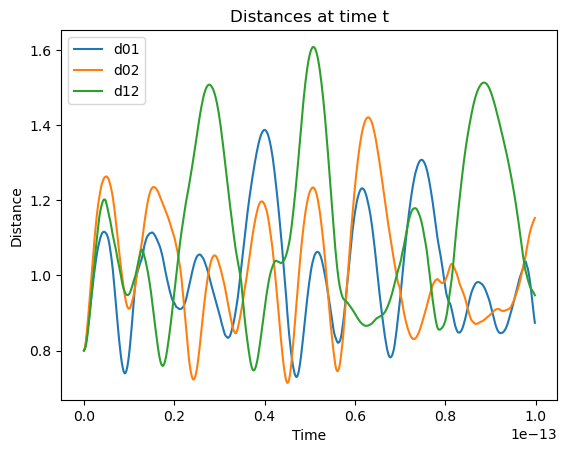

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()